
# Testing a Potential Moderator

In [1]:

%run ../data-visualization/load-gapminder_df.ipynb
%who

MinMaxScaler	 angle_between	 attempt_to_pickle	 conjunctify_list	 create_binned_categories	 data_folder	 data_procedures_dict	 data_provider_dict	 download_url	 
encoding	 euclidean	 formal_name_dict	 gapminder_df	 get_min_max	 informal_name_dict	 load_object	 np	 number_column_list	 
obj_path	 original_columns	 os	 pd	 pdist	 pickle	 round_down	 round_up	 saves_folder	 
squareform	 store_objects	 unit_vector	 


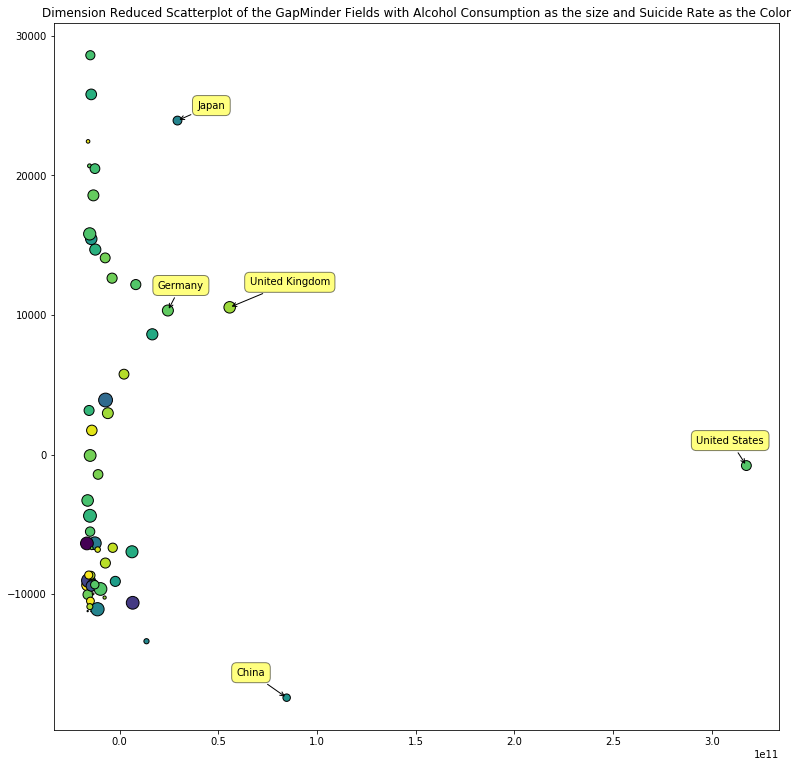

In [2]:

%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.cluster import DBSCAN

elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             s=elite_df['alcohol_consumption']*10,
                             c=elite_df['suicide_per_100th'],
                             edgecolors=(0, 0, 0), cmap=cmap)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for col, label, x, y in zip(labels, elite_df['country_name'],
                            elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), **kwargs)
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), **kwargs)
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-50, 20), **kwargs)
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), **kwargs)
title_text = 'Dimension Reduced Scatterplot of the GapMinder '
title_text += 'Fields with Alcohol Consumption as the size and '
title_text += 'Suicide Rate as the Color'
text = plt.title(title_text)


# Choose three features with a high ANOVA and low/high contrast

In [19]:

# Choose three features with a high anova contrast
rows_list = []
column_set_list = []
for ce_column_name in number_column_list:
    for qr_column_name in number_column_list:
        for md_column_name in number_column_list:
            moderation_columns_list = [ce_column_name, qr_column_name, md_column_name]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = gapminder_df.dropna(how='any', subset=moderation_columns_list).copy()
                    both_df = create_binned_categories(both_df, 2, md_column_name, 'md')
                    both_df = create_binned_categories(both_df, 2, ce_column_name, 'ce')

                    # Use ols function for calculating the F-statistic's associated p value
                    f_pvalue = smf.ols(formula=qr_column_name+' ~ C(ce_categories)',
                                       data=both_df).fit().f_pvalue
                    if f_pvalue < 0.05:

                        mask_series = (both_df['md_categories'] == both_df['md_categories'].min())
                        low_df = both_df[mask_series].copy()
                        low_mean_df = low_df.groupby('ce_categories').mean()
                        low_mean_diff = abs(low_mean_df.loc[1, qr_column_name] - low_mean_df.loc[0, qr_column_name])

                        mask_series = (both_df['md_categories'] == both_df['md_categories'].max())
                        high_df = both_df[mask_series].copy()
                        high_mean_df = high_df.groupby('ce_categories').mean()
                        high_mean_diff = abs(high_mean_df.loc[1, qr_column_name] - high_mean_df.loc[0, qr_column_name])

                        row_dict['ce_column_name'] = ce_column_name
                        row_dict['qr_column_name'] = qr_column_name
                        row_dict['md_column_name'] = md_column_name
                        row_dict['diff_diff'] = abs(high_mean_diff - low_mean_diff)
                        rows_list.append(row_dict)
anova_moderations_df = pd.DataFrame(rows_list, columns=['ce_column_name', 'qr_column_name', 'md_column_name', 'diff_diff'])
anova_moderations_df.sort_values('diff_diff', ascending=False).head(10)

,ce_column_name,qr_column_name,md_column_name,diff_diff
185,internet_use_rate,residential_electricity_per_person,employment_rate,2021.794120
145,life_expectancy,residential_electricity_per_person,employment_rate,1758.525760
22,breast_cancer_per_100th,residential_electricity_per_person,female_employment_rate,1573.102056
181,internet_use_rate,residential_electricity_per_person,alcohol_consumption,1536.600487
25,breast_cancer_per_100th,residential_electricity_per_person,armed_forces_rate,1328.254054
27,breast_cancer_per_100th,residential_electricity_per_person,employment_rate,1236.683641
186,internet_use_rate,residential_electricity_per_person,income_per_person,1122.613590
146,life_expectancy,residential_electricity_per_person,income_per_person,1068.401949
81,co2_emissions,residential_electricity_per_person,employment_rate,1002.622312
180,internet_use_rate,residential_electricity_per_person,urban_rate,893.969819


In [20]:
from IPython.core.display import display

column_name_list = anova_moderations_df.sort_values('diff_diff', ascending=False).head(1).values.tolist()[0]
sts = Statements(gapminder_df, number_of_categories=2,
                 ce_column_name=column_name_list[0], qr_column_name=column_name_list[1], md_column_name=column_name_list[2],
                 test_type='ols')
anova_with_moderator(sts, verbose=False)

/Users/davebabbitt/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1400: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid



# Choose three features with a high association and low/high contrast

In [21]:

# Choose three features with a high chi squared contrast
rows_list = []
column_set_list = []
for ce_column_name in number_column_list:
    for cr_column_name in number_column_list:
        for md_column_name in number_column_list:
            moderation_columns_list = [ce_column_name, cr_column_name, md_column_name]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = gapminder_df.dropna(how='any', subset=moderation_columns_list).copy()
                    both_df = create_binned_categories(both_df, 2, md_column_name, 'md')
                    both_df = create_binned_categories(both_df, 5, ce_column_name, 'ce')
                    both_df = create_binned_categories(both_df, 2, cr_column_name, 'cr')
                    
                    mask_series = (both_df['md_categories'] == both_df['md_categories'].min())
                    low_df = both_df[mask_series].copy()

                    # Get the low cross tab
                    low_crosstab_df = pd.crosstab(low_df['cr_categories'], low_df['ce_categories'])
                    low_crosstab_df = low_crosstab_df.loc[:, (low_crosstab_df != 0).any(axis=0)]

                    if low_crosstab_df.shape[0] > 0:

                        # Get the low statistic
                        low_css = chi2_contingency(low_crosstab_df)[0]

                    mask_series = (both_df['md_categories'] == both_df['md_categories'].max())
                    high_df = both_df[mask_series].copy()

                    # Get the high cross tab
                    high_crosstab_df = pd.crosstab(high_df['cr_categories'], high_df['ce_categories'])
                    high_crosstab_df = high_crosstab_df.loc[:, (high_crosstab_df != 0).any(axis=0)]

                    if high_crosstab_df.shape[0] > 0:

                        # Get the high statistic
                        high_css = chi2_contingency(high_crosstab_df)[0]
                    
                    row_dict['ce_column_name'] = ce_column_name
                    row_dict['cr_column_name'] = cr_column_name
                    row_dict['md_column_name'] = md_column_name
                    row_dict['css_diff'] = abs(high_css - low_css)
                    rows_list.append(row_dict)
chi_moderations_df = pd.DataFrame(rows_list, columns=['ce_column_name', 'cr_column_name', 'md_column_name', 'css_diff'])
chi_moderations_df.sort_values('css_diff', ascending=False).head(10)

,ce_column_name,cr_column_name,md_column_name,css_diff
112,co2_emissions,life_expectancy,employment_rate,36.231872
38,breast_cancer_per_100th,internet_use_rate,female_employment_rate,36.060875
322,internet_use_rate,alcohol_consumption,polity_score,35.504530
78,breast_cancer_per_100th,alcohol_consumption,polity_score,33.370490
72,breast_cancer_per_100th,urban_rate,armed_forces_rate,33.143506
241,life_expectancy,internet_use_rate,armed_forces_rate,30.919073
243,life_expectancy,internet_use_rate,employment_rate,29.900460
9,breast_cancer_per_100th,co2_emissions,armed_forces_rate,29.382872
277,life_expectancy,alcohol_consumption,polity_score,28.953463
291,internet_use_rate,residential_electricity_per_person,female_employment_rate,28.160577


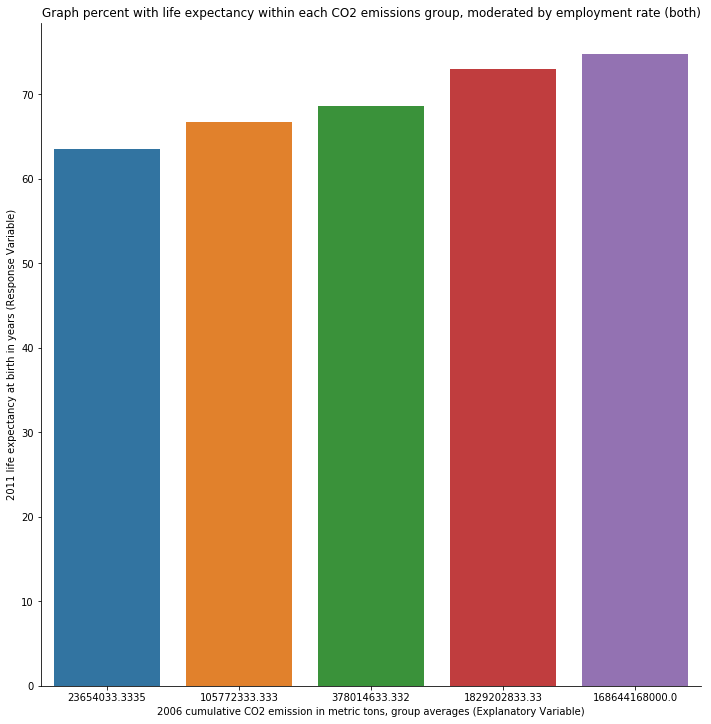

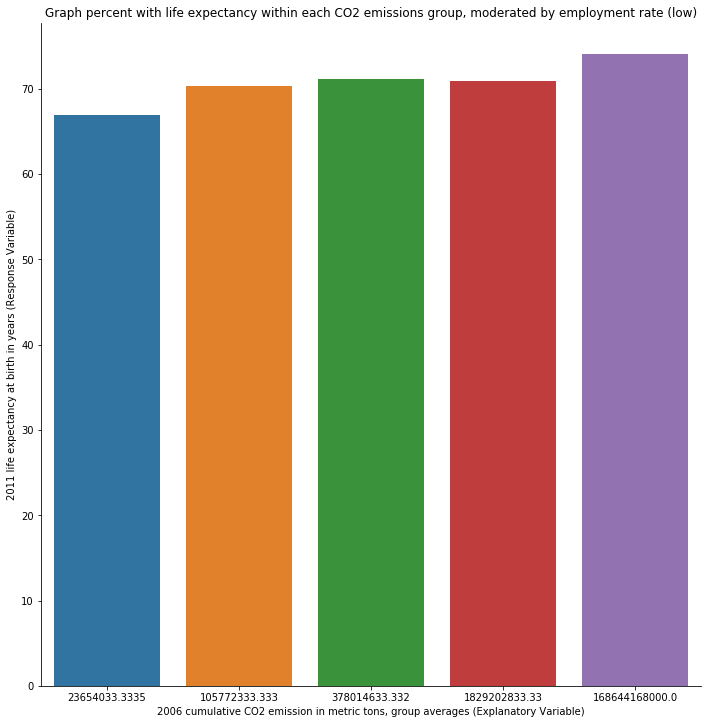

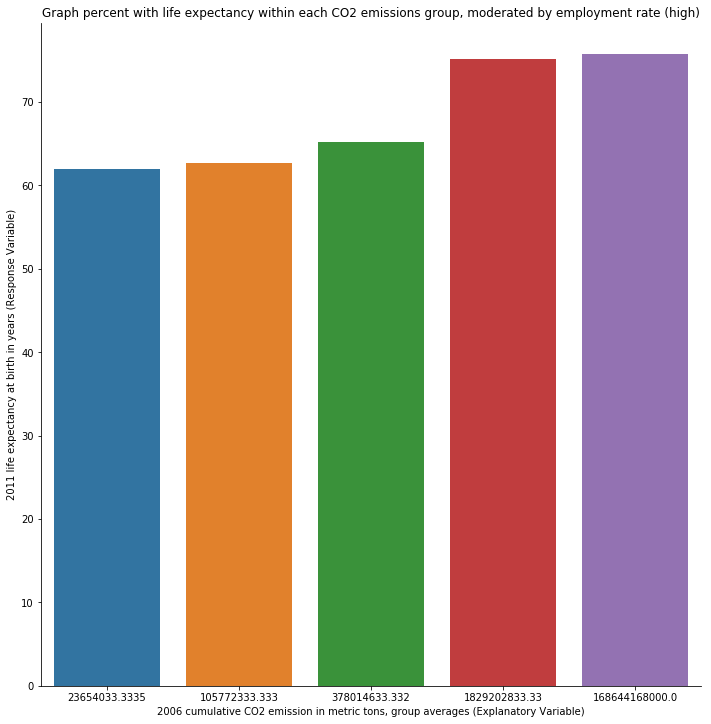

In [22]:

column_name_list = chi_moderations_df.sort_values('css_diff', ascending=False).head(1).values.tolist()[0]
sts = Statements(gapminder_df, number_of_categories=5,
                 ce_column_name=column_name_list[0], cr_column_name=column_name_list[1], md_column_name=column_name_list[2],
                 test_type='chi2')
chi_square_with_moderator(sts, verbose=True)


# Choose three features with a high r squared and low/high contrast

In [23]:

# Choose three features with a large low/high contrast
rows_list = []
column_set_list = []
for qe_column_name in number_column_list:
    for qr_column_name in number_column_list:
        for md_column_name in number_column_list:
            moderation_columns_list = [qe_column_name, qr_column_name, md_column_name]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = create_binned_categories(gapminder_df.dropna(how='any',
                                                                           subset=[qe_column_name, qr_column_name, md_column_name]).copy(),
                                                       2, md_column_name,'md')
                    mask_series = (both_df['md_categories'] == both_df['md_categories'].min())
                    low_df = both_df[mask_series].copy()
                    low_cod = pearsonr(low_df[qe_column_name], low_df[qr_column_name])[0]**2

                    mask_series = (both_df['md_categories'] == both_df['md_categories'].max())
                    high_df = both_df[mask_series].copy()
                    high_cod = pearsonr(high_df[qe_column_name], high_df[qr_column_name])[0]**2
                    
                    row_dict['qe_column_name'] = qe_column_name
                    row_dict['qr_column_name'] = qr_column_name
                    row_dict['md_column_name'] = md_column_name
                    row_dict['cod_diff'] = abs(high_cod - low_cod)
                    rows_list.append(row_dict)
moderations_df = pd.DataFrame(rows_list, columns=['qe_column_name', 'qr_column_name', 'md_column_name', 'cod_diff'])
moderations_df.sort_values('cod_diff', ascending=False).head(10)

,qe_column_name,qr_column_name,md_column_name,cod_diff
447,oil_per_person,armed_forces_rate,income_per_person,0.612496
47,breast_cancer_per_100th,residential_electricity_per_person,female_employment_rate,0.605936
124,co2_emissions,residential_electricity_per_person,hiv_rate,0.584362
48,breast_cancer_per_100th,residential_electricity_per_person,urban_rate,0.568953
81,breast_cancer_per_100th,oil_per_person,armed_forces_rate,0.559284
51,breast_cancer_per_100th,residential_electricity_per_person,armed_forces_rate,0.548309
446,oil_per_person,armed_forces_rate,employment_rate,0.502367
82,breast_cancer_per_100th,oil_per_person,polity_score,0.497645
322,internet_use_rate,alcohol_consumption,polity_score,0.441676
363,residential_electricity_per_person,oil_per_person,employment_rate,0.438302


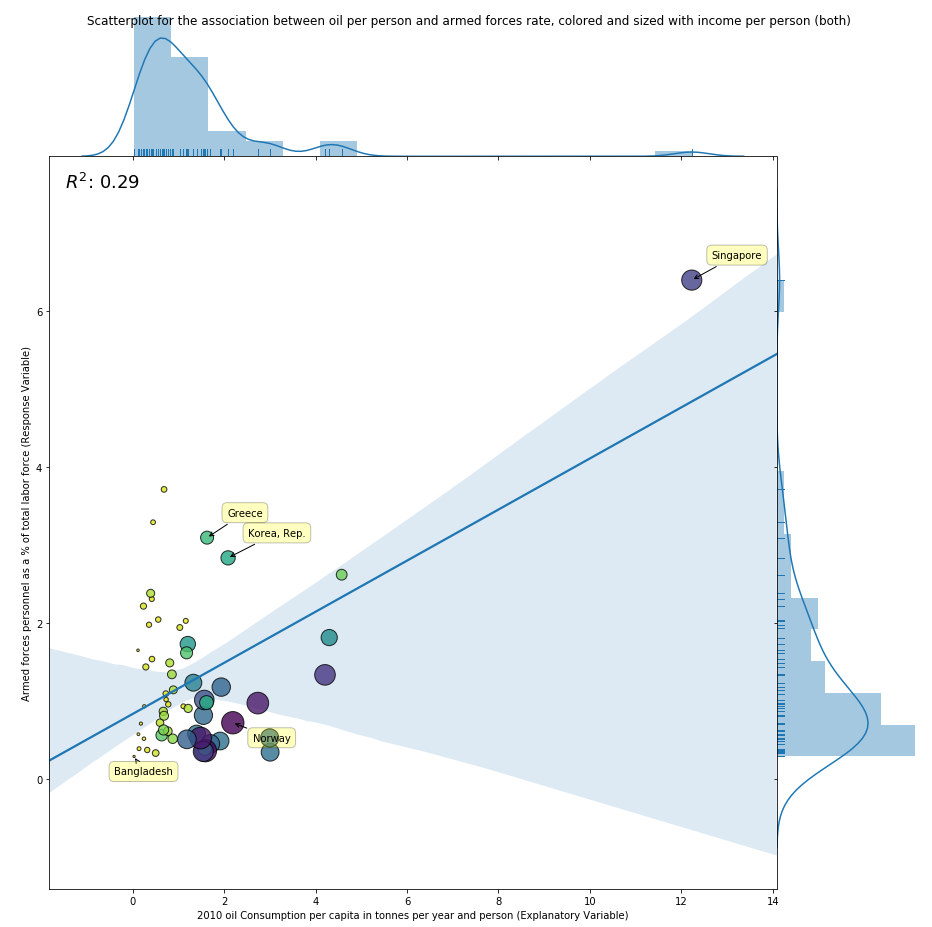

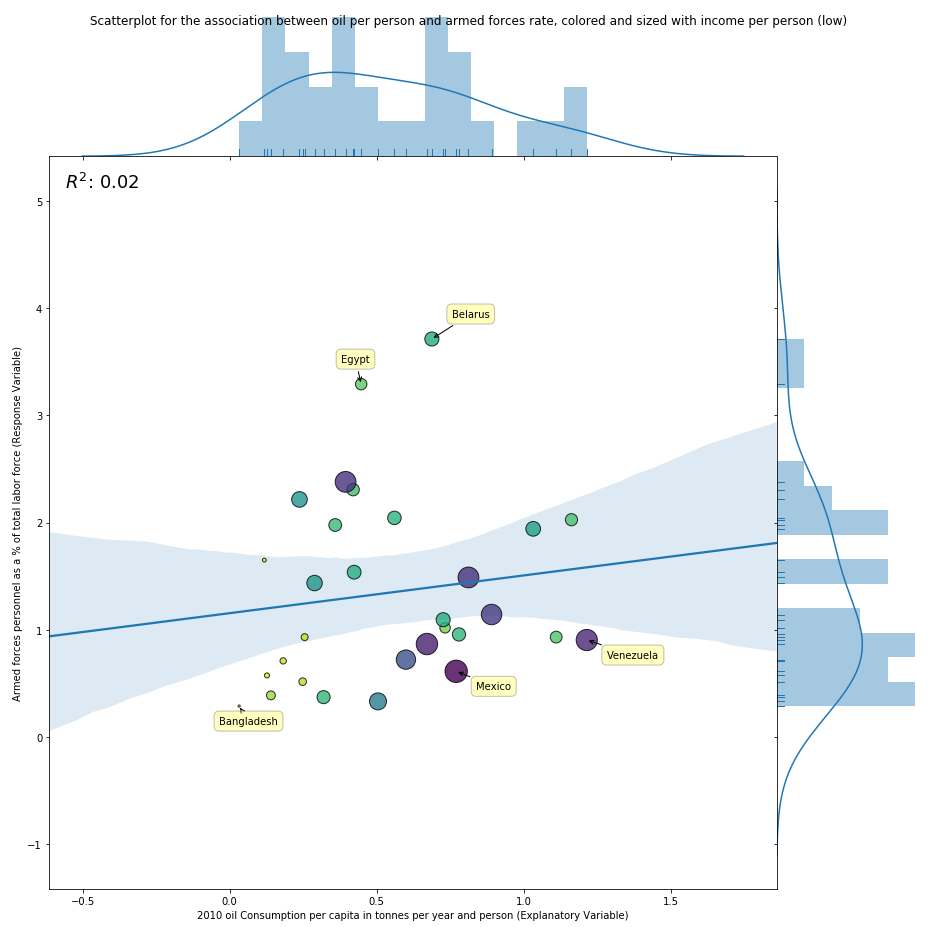

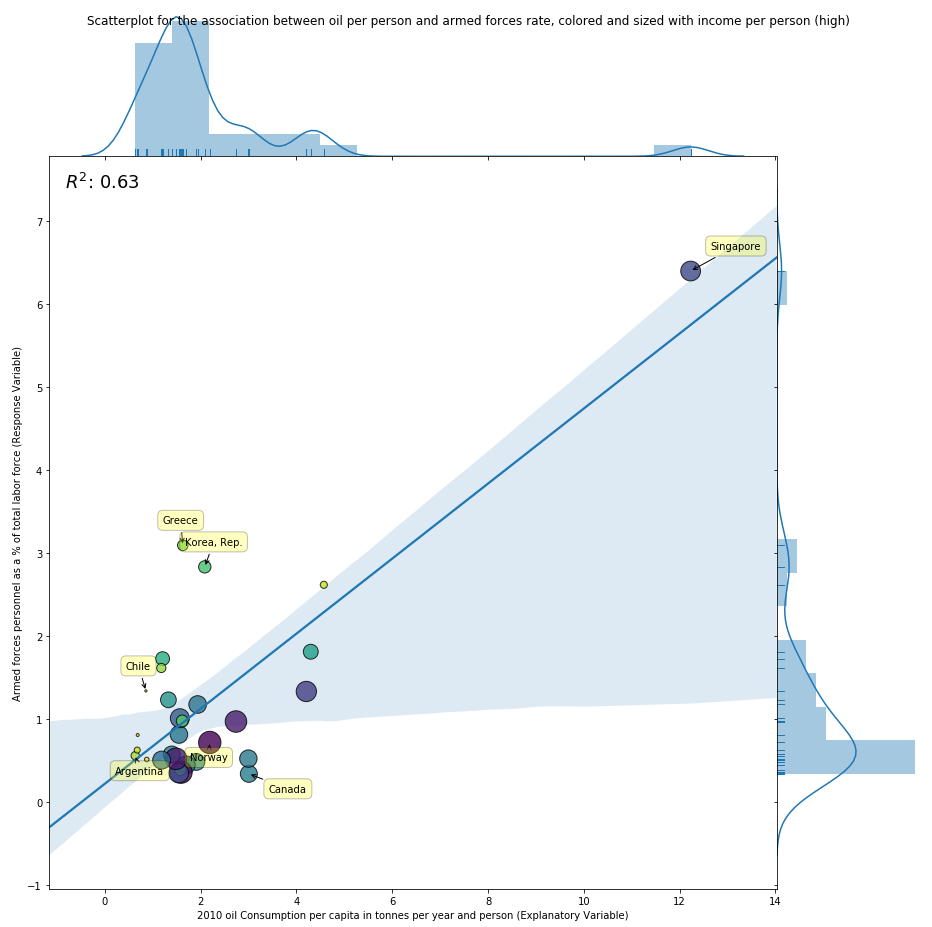

In [24]:

column_name_list = moderations_df.sort_values('cod_diff', ascending=False).head(1).values.tolist()[0]
sts = Statements(gapminder_df,
                 qe_column_name=column_name_list[0], qr_column_name=column_name_list[1], md_column_name=column_name_list[2])
pearsons_with_moderator(sts, verbose=True)

In [27]:

%%javascript
var kernel = IPython.notebook.kernel,  
    body = document.body,  
    attribs = body.attributes,  
    command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [28]:
# %load ../../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/' + notebook_path
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')